<a href="https://colab.research.google.com/github/navneetslovely/QML_genom/blob/main/VQC_ZFeatureMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
!pip install qiskit-machine-learning
!pip install qiskit[visualization]
!pip install genomic-benchmarks
!pip install tensorflow>=2.6.0
!pip install tensorflow-addons
!pip install typing-extensions --upgrade
!pip install qiskit-aer

Mounted at /content/drive
/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512613 sha256=8b77b8d635847ed16e98c6f3bf655886e81d71430f5a6

In [2]:
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded, info
from genomic_benchmarks.models.tf import vectorize_layer
from genomic_benchmarks.models.tf import get_basic_cnn_model_v0 as get_model
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.decomposition import PCA
algorithm_globals.random_seed = 42

In [3]:
# Load the preprocessed data
train_sequences = np.load('train_sequences.npy')
# print('train_sequences',train_sequences[:2])
train_labels = np.load('train_labels.npy')
# print('train_labels',train_labels[:2])
test_sequences = np.load('test_sequences.npy')
# print('test_sequences',test_sequences[:2])
test_labels = np.load('test_labels.npy')
# print('test_labels',test_labels[:2])
# Perform PCA transformation on the data
pca = PCA(n_components=4)
train_sequences = pca.fit_transform(train_sequences)
test_sequences= pca.fit_transform(test_sequences)

# Split the train_sequences, train_labels, test_sequences, and test_labels into 15 parts each
split_train_sequences = np.array_split(train_sequences, 15)
split_train_labels = np.array_split(train_labels, 15)
split_test_sequences = np.array_split(test_sequences, 15)
split_test_labels = np.array_split(test_labels, 15)

# Create directories to save the parts
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_sequences_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_labels_parts', exist_ok=True)

# Save each part into a separate file
for i in range(15):
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts/train_seq_{i+1}.npy', split_train_sequences[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts/train_labels_{i+1}.npy', split_train_labels[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_sequences_parts/test_seq_{i+1}.npy', split_test_sequences[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_labels_parts/test_labels_{i+1}.npy', split_test_labels[i])

In [4]:
# Define the feature dimension or number of qubits
feature_dim = len(train_sequences[0])
print("Feature dimension and number of qubits:", feature_dim)

Feature dimension and number of qubits: 4


In [6]:
from qiskit.circuit.library import ZFeatureMap

feature_dim = len(train_sequences[0])
prep = ZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# qc= QNNCircuit(num_qubits=feature_dim ,ansatz = ansatz, feature_map=prep)
itr=0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr} {obj_func_eval}", end=' | ')
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

# feature_map = RawFeatureVector(feature_dimension=feature_dim)
# ansatz = RealAmplitudes(num_qubits = feature_dim, reps=4)
optimizer = COBYLA(maxiter=40)
vqc = VQC(
        feature_map=prep,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=Sampler(),
        callback=partial(training_callback)
)

In [7]:
num_epochs = 10  # Specify the number of epochs
batch_size = 1024  # Specify the batch size
total_time = 0

# Placeholder for saving scores
train_scores = []
test_scores = []

Training on part 1 started
1 1.1312332248349168 | 2 1.133148858012635 | 3 1.1196455089130386 | 4 1.1268865205087746 | 5 1.123408727552014 | 6 1.0885998984739524 | 7 1.0685926329959445 | 8 1.0723647798709899 | 9 1.066073062174385 | 10 1.0526272521227187 | 11 1.0876309821096566 | 12 1.0536134987504961 | 13 1.0714644286391777 | 14 1.0518700649338801 | 15 1.078011023000807 | 16 1.04801023013646 | 17 1.0408132883160905 | 18 1.0874578660410328 | 19 1.0408132883160905 | 20 1.0408132883160905 | 21 1.0408132883160905 | 22 1.0358361050435454 | 23 1.0251230173799026 | 24 1.1190956698747567 | 25 1.0206756656128146 | 26 1.0263160921363923 | 27 1.024093045012099 | 28 1.0498235654406238 | 29 1.0206001187253362 | 30 1.0294935362668323 | 31 1.0255535027158782 | 32 1.010514348860212 | 33 1.0077650884007876 | 34 1.0304333774283991 | 35 1.014533531192282 | 36 1.0220458553567604 | 37 1.007387069218961 | 38 1.0113246449836852 | 39 1.0081873615236252 | 40 1.0228451320900187 | Epoch 1, Part 1 - Batch 1 comple

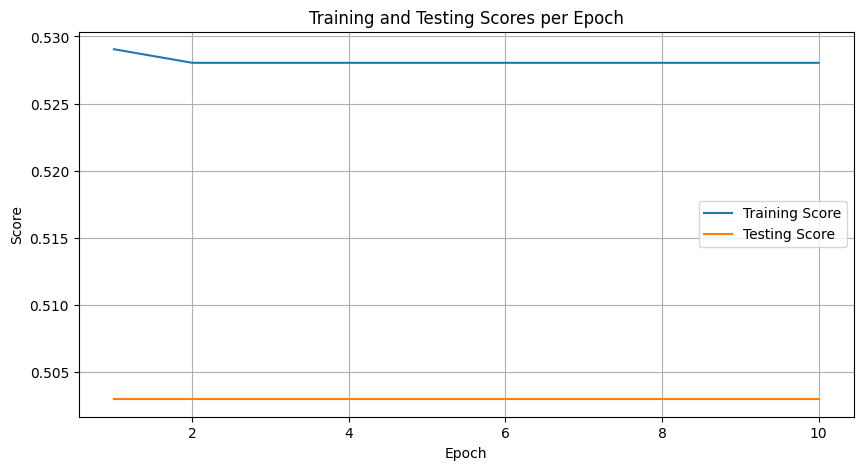

In [8]:
# Loop over each epoch
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    epoch_train_scores = []  # Store training scores for each epoch

    # Loop over each data split
    for a in range(1, 5):
        # Load the split data
        train_sequences_part = np.load(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts/train_seq_{a}.npy')
        train_labels_part = np.load(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts/train_labels_{a}.npy')

        print(f"Training on part {a} started")

        # Perform training for each batch
        for i in range(0, len(train_sequences_part), batch_size):
            batch_sequences = train_sequences_part[i:i+batch_size]
            batch_labels = train_labels_part[i:i+batch_size]

            # Fit the model on the batch
            vqc.fit(batch_sequences, batch_labels)

            # # Optionally evaluate on training data
            score = vqc.score(batch_sequences, batch_labels)
            epoch_train_scores.append(score)

            print(f"Epoch {epoch + 1}, Part {a} - Batch {i // batch_size + 1} completed")

        # Optionally, save the model after each part is processed within an epoch
        vqc.save(f'VQC_ZFeatureMap_after_part_{a}_epoch_{epoch+1}')
        print(f"Model saved after part {a}, epoch {epoch+1} completed")

    # Average training score for the epoch
    average_train_score = np.mean(epoch_train_scores)
    train_scores.append(average_train_score)

    # Evaluate on the entire test dataset after each epoch
    test_score = vqc.score(test_sequences[:4000], test_labels[:4000])
    test_scores.append(test_score)

    print(f"Epoch {epoch+1} - Training Score: {average_train_score:.4f}, Test Score: {test_score:.4f}")

    vqc.save(f'VQC_ZFeatureMap_epoch_{epoch+1}')
    print(f"Model saved after epoch {epoch+1} completed")

    # Calculate the time for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    total_time += epoch_time

    print(f"Epoch {epoch+1} - Time taken: {epoch_time:.2f} seconds")

print(f"Total training time: {total_time:.2f} seconds")

# Save scores to a file for later use
# np.save('VQC_train_scores_ZZFeatureMap.npy', np.array(train_scores))
# np.save('VQC_test_scores_ZZFeatureMap.npy', np.array(test_scores))
train_scores_file = 'VQC_train_scores_ZFeatureMap.npy'
test_scores_file = 'VQC_test_scores_ZFeatureMap.npy'
if os.path.exists(train_scores_file):
    existing_train_scores = np.load(train_scores_file)
    updated_train_scores = np.concatenate((existing_train_scores, train_scores))
    np.save(train_scores_file, updated_train_scores)
else:
    np.save(train_scores_file, np.array(train_scores))

if os.path.exists(test_scores_file):
    existing_test_scores = np.load(test_scores_file)
    updated_test_scores = np.concatenate((existing_test_scores, test_scores))
    np.save(test_scores_file, updated_test_scores)
else:
    np.save(test_scores_file, np.array(test_scores))
# Plot the training and testing scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_scores, label='Training Score')
plt.plot(range(1, num_epochs + 1), test_scores, label='Testing Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Testing Scores per Epoch')
plt.legend()
plt.grid(True)
plt.show()
